<a href="https://colab.research.google.com/github/al3co198909/al3co198909/blob/main/first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
  gpu_num = 0
  os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
  print(f"Set CUDA_VISIBLE_DEVICES to {gpu_num}")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


Set CUDA_VISIBLE_DEVICES to 0


In [4]:
try:
  import sionna
except ImportError as e:
  import os
  os.system("pip install sionna")
  import sionna

In [5]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

tf.get_logger().setLevel("ERROR")

sionna.config.seed = 42

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

In [7]:
num_tx_ant = 4
num_rx_ant = 16
num_bits_per_symbol = 4
batch_size = 1024
qam_source = QAMSource(num_bits_per_symbol)
x = qam_source([batch_size, num_tx_ant])
print(x.shape)

(1024, 4)


In [8]:
channel = FlatFadingChannel(num_tx_ant, num_rx_ant, add_awgn=True, return_channel=True)
no = 0.2 # Noise variance of the channel

# y and h are the channel output and channel realizations, respectively.
y, h = channel([x, no])
print(y.shape)
print(h.shape)

(1024, 16)
(1024, 16, 4)


In [9]:
s = tf.cast(no*tf.eye(num_rx_ant, num_rx_ant), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)

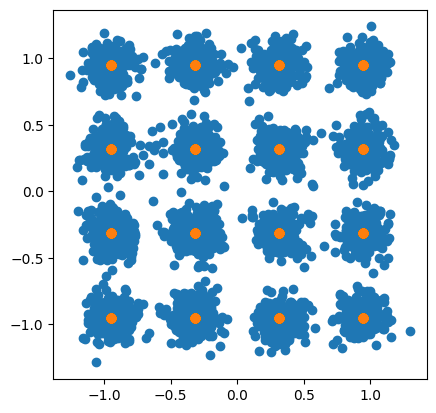

In [10]:
plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat), np.imag(x_hat));
plt.scatter(np.real(x), np.imag(x));

In [11]:
print(no_eff.shape)

(1024, 4)


In [12]:
noise_var_eff = np.var(x-x_hat)
noise_var_est = np.mean(no_eff)
print(noise_var_eff)
print(noise_var_est)

0.015844796
0.016486917


In [13]:
symbol_demapper = SymbolDemapper("qam", num_bits_per_symbol, hard_out=True)

# Get symbol indices for the transmitted symbols
x_ind = symbol_demapper([x, no])

# Get symbol indices for the received soft-symbols
x_ind_hat = symbol_demapper([x_hat, no])

compute_ser(x_ind, x_ind_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=0.00244140625>

In [14]:
# Create transmit and receive correlation matrices
r_tx = exp_corr_mat(0.4, num_tx_ant)
r_rx = exp_corr_mat(0.9, num_rx_ant)

# Add the spatial correlation model to the channel
channel.spatial_corr = KroneckerModel(r_tx, r_rx)

In [15]:
h = channel.generate(1000000)

# Compute empirical covariance matrices
r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/num_rx_ant
r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/num_tx_ant

# Test that the empirical results match the theory
assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

In [16]:
y, h = channel([x, no])
x_hat, no_eff = lmmse_equalizer(y, h, s)
x_ind_hat = symbol_demapper([x_hat, no])
compute_ser(x_ind, x_ind_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=0.121337890625>

In [17]:
n = 1024
k = 512
coderate = k/n
batch_size = 32

binary_source = BinarySource()
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder, hard_out=True)
mapper = Mapper("qam", num_bits_per_symbol)
demapper = Demapper("app", "qam", num_bits_per_symbol)

In [18]:
b = binary_source([batch_size, num_tx_ant, k])
c = encoder(b)
x = mapper(c)
x_ind = symbol_demaper([x, no])
shape = tf.shape(x)
x = tf.reshape(x, [-1, num_tx_ant])
print(x.shape)

NameError: name 'symbol_demaper' is not defined

In [ ]:
y, h = channel([x, no])
x_hat, no_eff = lmmse_equalizer(y, h, s)

In [ ]:
x_ind_hat.shape

TensorShape([8192, 4])

In [ ]:
x_hat = tf.reshape(x_hat, shape)
no_eff = tf.reshape(no_eff, shape)

llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)

x_ind_hat = symbol_demapper([x_hat, no])
ber = compute_ber(b, b_hat).numpy()
print("Uncoded SER : {}".format(compute_ser(x_ind, x_ind_hat)))
print("Coded BER : {}".format(compute_ber(b, b_hat)))

Uncoded SER : 0.123260498046875
Coded BER : 0.0


In [20]:
sionna.config.xla_compat=True
class Model(tf.keras.Model):
    def __init__(self, spatial_corr=None):
        super().__init__()
        self.n = 1024
        self.k = 512
        self.coderate = self.k/self.n
        self.num_bits_per_symbol = 4
        self.num_tx_ant = 4
        self.num_rx_ant = 16
        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        b = self.binary_source([batch_size, self.num_tx_ant, self.k])
        c = self.encoder(b)

        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)

        y, h = self.channel([x, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)

        x_hat, no_eff = lmmse_equalizer(y, h, s)

        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)

        llr = self.demapper([x_hat, no_eff])
        b_hat = self.decoder(llr)

        return b,  b_hat

XLA can lead to reduced numerical precision. Use with care.


In [21]:
ber_plot = PlotBER()

In [22]:
model1 = Model()

ber_plot.simulate(model1,
        np.arange(-2.5, 0.25, 0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=100,
        legend="Uncorrelated",
        show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.5 | 1.1193e-01 | 9.2218e-01 |      938977 |     8388608 |        15109 |       16384 |        13.0 |reached target block errors
    -2.25 | 8.0181e-02 | 7.9395e-01 |      672609 |     8388608 |        13008 |       16384 |         0.8 |reached target block errors
     -2.0 | 5.0235e-02 | 5.8643e-01 |      421402 |     8388608 |         9608 |       16384 |         0.8 |reached target block errors
    -1.75 | 2.7254e-02 | 3.6865e-01 |      228624 |     8388608 |         6040 |       16384 |         0.8 |reached target block errors
     -1.5 | 1.1748e-02 | 1.9055e-01 |       98550 |     8388608 |         3122 |       16384 |         0.8 |reached target block errors
    -1.25 | 4.4769e-03 | 7.9041e-02 |       37555 |     8388608 |

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.1802e-02 | 7.2089e-01 |      602318 |     8388608 |        11811 |       16384 |         7.1 |reached target block errors
     0.25 | 4.7197e-02 | 5.3821e-01 |      395914 |     8388608 |         8818 |       16384 |         0.9 |reached target block errors
      0.5 | 2.6843e-02 | 3.5272e-01 |      225172 |     8388608 |         5779 |       16384 |         0.9 |reached target block errors
     0.75 | 1.4102e-02 | 1.9727e-01 |      118293 |     8388608 |         3232 |       16384 |         0.9 |reached target block errors
      1.0 | 5.9897e-03 | 9.5581e-02 |       50245 |     8388608 |         1566 |       16384 |         0.9 |reached target block errors
     1.25 | 2.4159e-03 | 4.1077e-02 |       20266 |     8388608 |

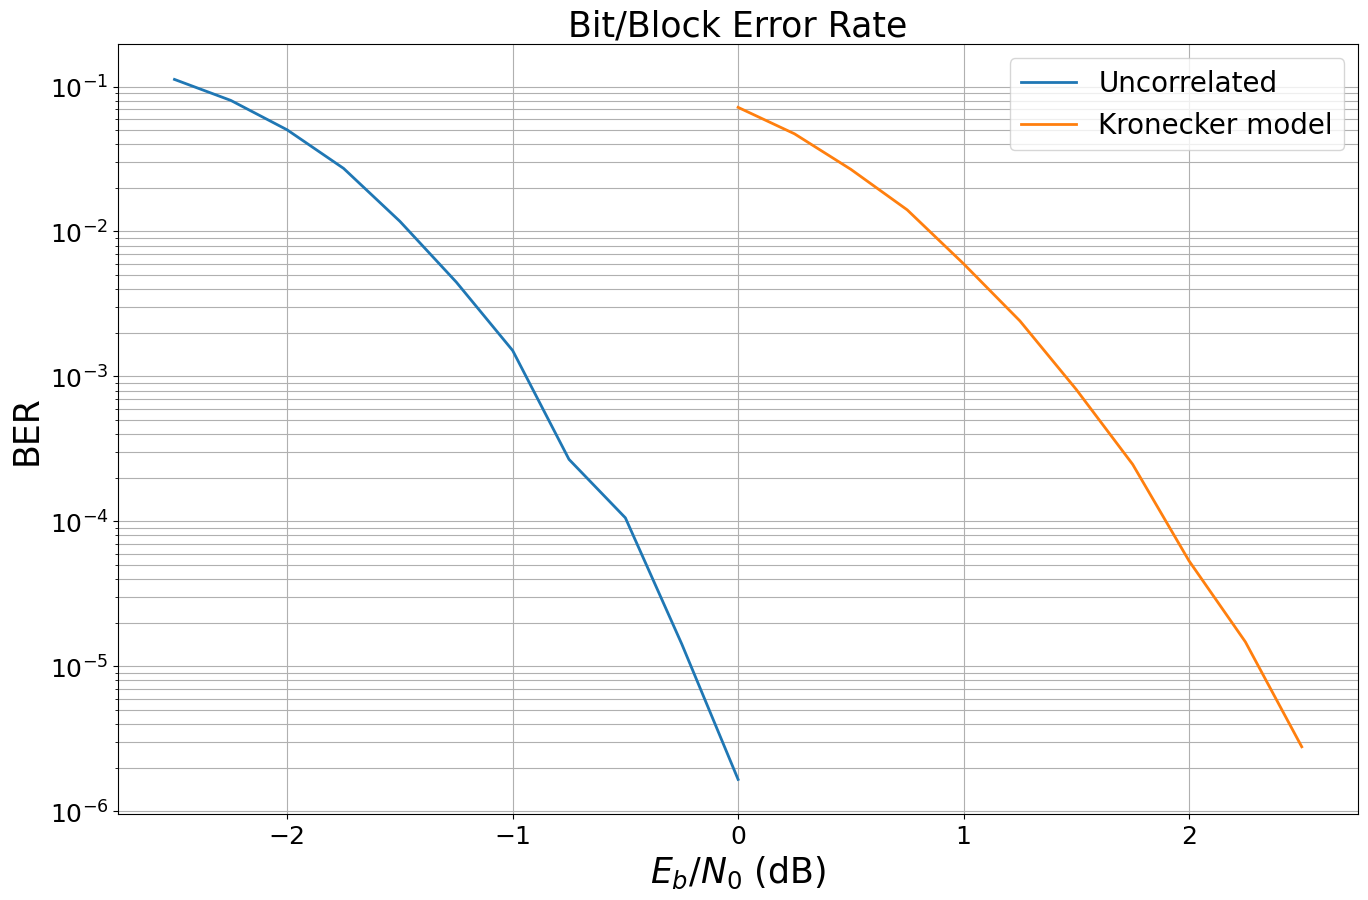

In [23]:
r_tx = exp_corr_mat(0.4, num_tx_ant)
r_rx = exp_corr_mat(0.7, num_rx_ant)
model2 = Model(KroneckerModel(r_tx, r_rx))

ber_plot.simulate(model2,
        np.arange(0,2.6,0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=200,
        legend="Kronecker model");